# Import needed modules and useful functions

In [1]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl
from scipy import integrate

#-- to computer fes --#
from mlcvs.utils.fes import compute_fes

#-- to run process from jupyter --#
import subprocess
import os
from pathlib import Path
# execute bash command in the given folder
def execute(command, folder, background=False):
    cmd = subprocess.run(command, cwd=folder, shell=True, capture_output = True, text=True, close_fds=background)
    if cmd.returncode == 0:
        print(f'Completed: {command}')
    else:
        print(cmd.stderr)

#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
folder = "angles/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
ene: ENERGY

INCLUDE FILE=plumed_descriptors.data

opes: OPES_METAD ARG=phi,psi TEMP=300 PACE=500 BIASFACTOR=inf SIGMA=0.15,0.15 FILE=KERNELS BARRIER=40 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10

PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

#-- run gromacs --#
#execute("cp script/input.* script/plumed_descriptors.data "+folder,folder=".")
#execute("./run_gromacs.sh",folder=folder)

Text(0, 0.5, '$\\psi$')

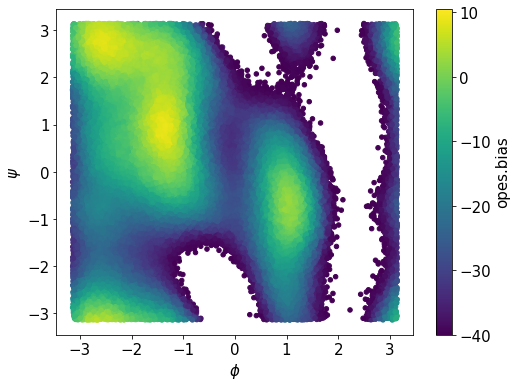

In [4]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
load_dataframe(folder+"COLVAR").plot.scatter(y="psi",x="phi",c="opes.bias",cmap="viridis",ax=ax)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

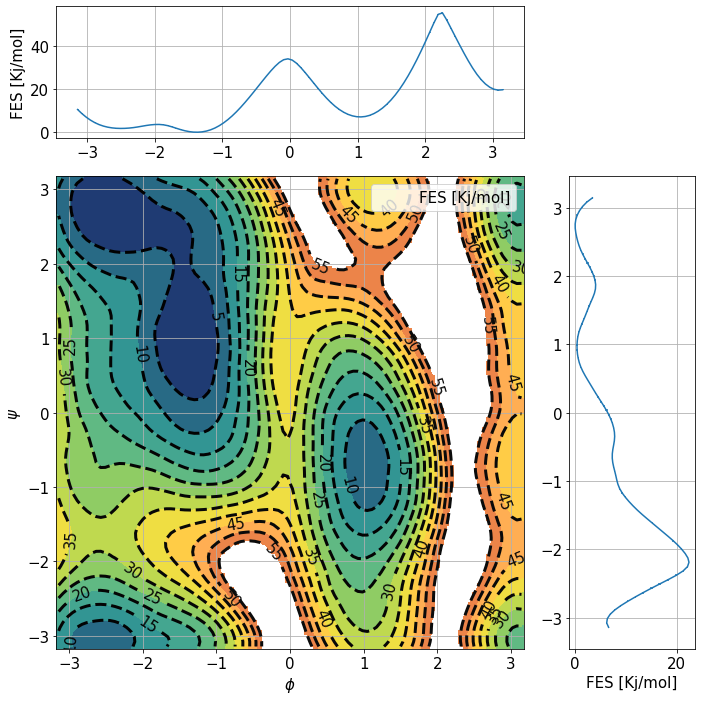

In [6]:
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]*sim_parameters["beta"]

fig = plt.figure(figsize=(10,10))
gs = GridSpec(4, 4)#, figure=fig)

ax_scatter = fig.add_subplot(gs[1:4,0:3])
ax_hist_x = fig.add_subplot(gs[0,:3])
ax_hist_y = fig.add_subplot(gs[1:,3])

#-- 2D plot --#
fes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),
                                    temp=sim_parameters["temp"],
                                    kbt=sim_parameters["kbt"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range')
                                    #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_scatter)
bounds = np.arange(0, 60, 5.)
cmap = plt.cm.get_cmap('fessa',len(bounds))
colors = list(cmap(np.arange(len(bounds))))
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over("white")
c = ax_scatter.pcolormesh(grid[0], grid[1], fes, cmap=cmap,shading='auto',alpha=1,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]"
)
c = ax_scatter.contourf(grid[0], grid[1], fes, bounds , cmap=cmap,shading='auto',alpha=1, linewidth=10,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
#fig.colorbar(c, ax=ax_scatter,label="FES [KbT]")
c = ax_scatter.contour(grid[0], grid[1], fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
ax_scatter.legend(["FES [Kj/mol]"])
c.clabel()
ax_scatter.grid()
ax_scatter.set_xlabel(r"$\phi$")
ax_scatter.set_ylabel(r"$\psi$")
np.savetxt(folder+"fes.txt",fes,delimiter=" ")
np.savetxt(folder+"grid0.txt",grid[0],delimiter=" ")
np.savetxt(folder+"grid1.txt",grid[1],delimiter=" ")

#-- 1D plot --#
fes,grid,bounds,error = compute_fes(s[:,0], weights=np.exp(logweight),
                                    temp=sim_parameters["temp"],
                                    kbt=sim_parameters["kbt"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range')
ax_hist_x.errorbar(grid,fes,yerr=error)
ax_hist_x.set_ylabel("FES [Kj/mol]")
ax_hist_x.grid()
                                    #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_hist_y)
fes,grid,bounds,error = compute_fes(s[:,1], weights=np.exp(logweight),
                                    temp=sim_parameters["temp"],
                                    kbt=sim_parameters["kbt"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range')
                                    #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_hist_x)
ax_hist_y.errorbar(fes,grid,xerr=error)
ax_hist_y.set_xlabel("FES [Kj/mol]")
ax_hist_y.grid()

plt.tight_layout()
plt.show()

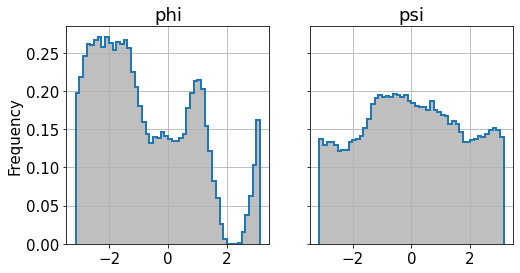

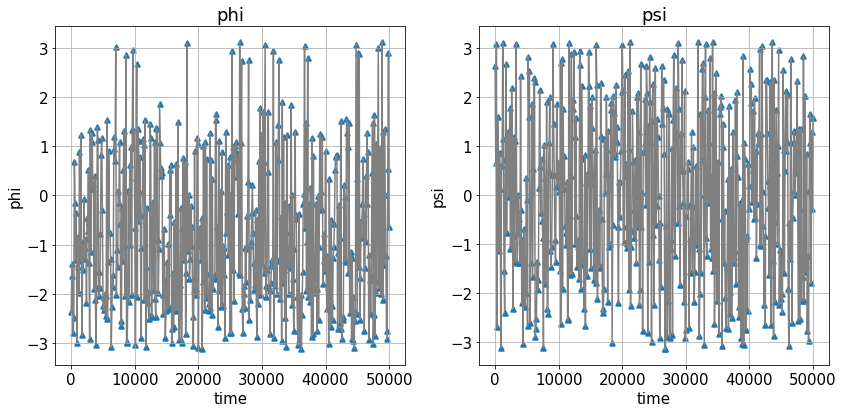

In [8]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(12,6))

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[::100].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
    data[::100].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
    ax.set_title(desc)

plt.tight_layout()